In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, median_absolute_error, mean_squared_error

## 1. Importar conjunto de datos

In [23]:
# Lectura de los datos

loc = r"../Datos/winequality-red.csv" # Ubicación del archivo
data = pd.read_csv(loc,sep=";",)      # Importar datos usando Pandas

names = list(data.columns.values)
label = list(data["alcohol"])
Xlist = (data.drop(["quality","alcohol"],1))
Xlist = [Xlist.iloc[i] for i in range(len(Xlist))]

## 2. Normalización de variables

In [27]:
# Normalización de columnas en X y etiquetas
nrows = len(Xlist)       # Numero de filas
ncols = len(Xlist[0])    # Numero de columnas

# Medias y varianzas
xMeans = []    # Lista vacia para almacenar medias
xSD = []       # Lista vacia para almacenar varianzas

# Cálculo manual del promedio y desviación estándar 

for i in range(ncols):
    col = [Xlist[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    xMeans.append(mean)
    colDiff = [(Xlist[j][i]-mean) for j in range(nrows)]
    sumSq = sum([colDiff[i]**2 for i in range(nrows)])
    stdDev = np.sqrt(sumSq/nrows)
    xSD.append(stdDev)

# Uso de la media y desviación para normalizar

xNormalized = []

for i in range(nrows):
    rowNormalized = [(Xlist[i][j] - xMeans[j])/xSD[j] for j in range(ncols)]
    xNormalized.append(rowNormalized)

In [28]:
# Construcción del loop para la validación cruzada

nxval = 10                            # Número de validaciones cruzadas
nsteps = 350                          # Número de pasos
stepSize = 0.004                      # Tamaño del paso

# Inicialización de la lista para almacenar errores

errors = []
for i in range(nsteps):
    b = []
    errors.append(b)
nzlist = []

for ixval in range(nxval):
    
    # Definir los índices en los conjuntos de entrenamiento y prueba
    idxTest = [a for a in range(nrows) if a%nxval==ixval*nxval]
    idxTrain = [a for a in range(nrows) if a%nxval != ixval*nxval]
    
    xTrain = [xNormalized[r] for r in idxTrain]
    xTest = [xNormalized[r] for r in idxTest]
    labelTrain = [label[r] for r in idxTrain]
    labelTest = [label[r] for r in idxTest]
    
    # Entrenamiento de LARS
    nrowsTrain = len(idxTrain)
    nrowsTest = len(idxTest)

    # Inicializaciión de betas
    beta=[0.0]*ncols

    betaMat=[]
    betaMat.append(list(beta))

    for iStep in range(nsteps):
        #cálculo de residuales
        residuals=[0.0]*nrows
        for j in range(nrowsTrain):
            labelsHat=sum([xTrain[j][k]*beta[k] for k in range(ncols)])
            residuals[j]=labelTrain[j]-labelsHat
        # Cálculo de la correlación entre los atributos columna
        corr=[0.0]*ncols

        for j in range(ncols):
            corr[j]=sum([xTrain[k][j]*residuals[k] for k in range(nrowsTrain)])/nrowsTrain

        iStar=0
        corrStar=corr[0]

        for j in range(1,(ncols)):
            if abs(corrStar)<abs(corr[j]):
                iStar=j; corrStar=corr[j]
        beta[iStar]+=stepSize*corrStar/abs(corrStar)
        betaMat.append(list(beta))

        # Uso de beta para predecir y calcular el error acumulado
        for j in range(nrowsTest):
            labelsHat=sum([xTest[j][k]*beta[k] for k in range(ncols)])
            err=labelTest[j]-labelsHat
            errors[iStep].append(err)

Minimun Mean Square error 109.53374332427919
Index of Minimum Mean Square Error 50


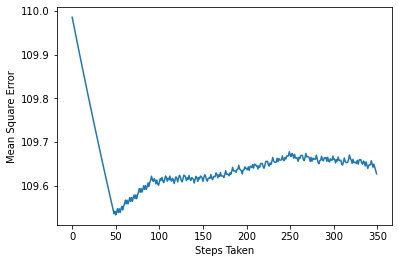

In [30]:
cvCurve=[]

for errVect in errors:
    mse=sum([x*x for x in errVect])/len(errVect)
    cvCurve.append(mse)

minMse = min(cvCurve)
minPt = [i for i in range(len(cvCurve)) if cvCurve[i]==minMse][0]
print("Minimun Mean Square error", minMse)
print("Index of Minimum Mean Square Error",minPt)

xaxis=range(len(cvCurve))
plt.plot(xaxis,cvCurve)

plt.xlabel("Steps Taken")
plt.ylabel(("Mean Square Error"))
plt.show()

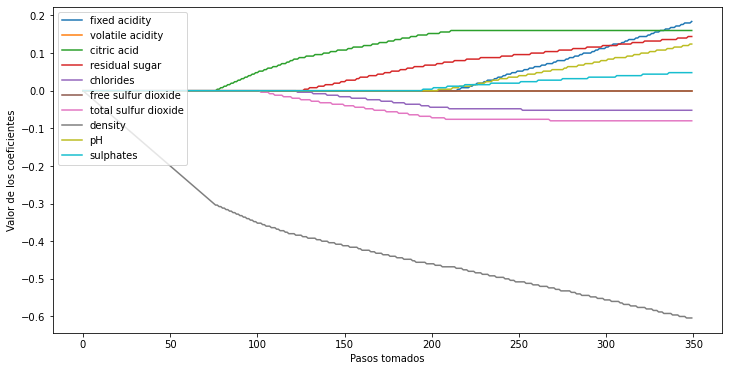

In [33]:
plt.figure(figsize=(12,6))
for i in range(ncols):
    # valores de beta por cada atributo
    coefCurve=[betaMat[k][i] for k in range(nsteps)]
    xaxis=range(nsteps)
    plt.plot(xaxis,coefCurve,label=names[i])
    plt.legend(loc='upper left')

plt.ylabel("Valor de los coeficientes")
plt.xlabel("Pasos tomados")
plt.show()